In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import datetime
from sklearn import mixture
from sklearn.externals.six.moves import xrange
import itertools
from scipy import linalg
from sklearn.cluster import KMeans
from itertools import compress
import itertools
from matplotlib.pyplot import cm
from geopy.distance import great_circle


%matplotlib inline

### Set up
#### Functions used in later process

In [29]:
def t_dist(str1, str2):
    
    t1 = datetime.datetime.strptime(str1, '%Y-%m-%d %H:%M:%S')
    t2 = datetime.datetime.strptime(str2, '%Y-%m-%d %H:%M:%S')
    
    if t2>t1:
        return (t2-t1).total_seconds()
    else:
        return (t1-t2).total_seconds()
     

def read_NY_NY(name):
    
    d, timestr = [], []
    path = 'new_york/{}.csv'.format(name)
    with open(path,'r') as f:
        for line in f:  
            l = line.strip().split(',')
            timestr.append(datetime.datetime.strptime(l[0], '%Y-%m-%d %H:%M:%S') )
            #d.append([float(l[1]), float(l[2]), t_dist(l[0], '1970-01-01 00:00:00') ])
            d.append([float(l[1]), float(l[2]), datetime.datetime.strptime(l[0], '%Y-%m-%d %H:%M:%S')])
    
    return np.array(d)

### Gaussian Mixure Model

#### For each individual's time-stamped location data, I applied a gaussian mixure model to find out what some key locations are generating these coordinates. I am assuming 4 locations/components. 2 of them represent home location after work before midnight and home location before work after midnight since time is one of the dimensions which naturally separate possible home location to two. 1 of 5 represents work location, including places for lunch. The rest represent other types of activity. I only use weekday data since commuter travel pattern is more consistent over weekdays. 

#### One individual example

#### There are four unique colors with each representing one cluster. One cluster of dots are generated by one hidden key location following assumed distribution. I only shows two combinations of two of three dimensions. 

/Users/yiyange/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


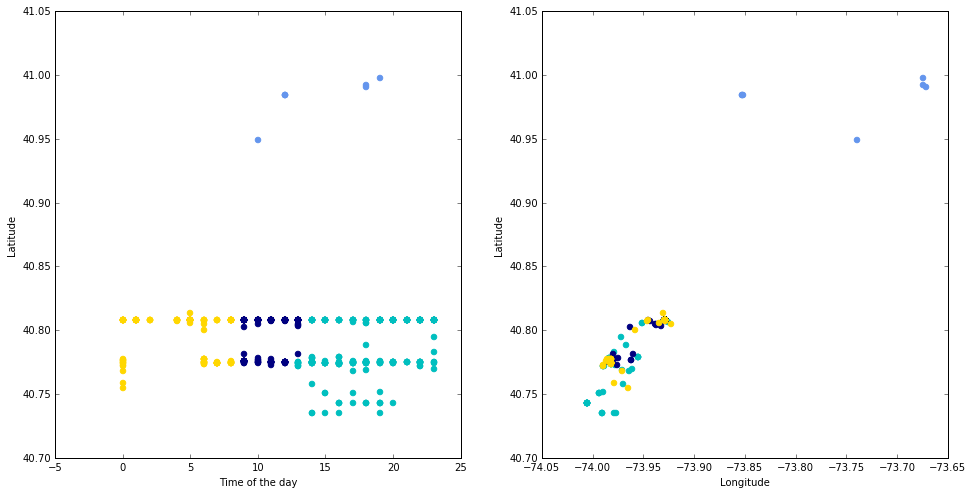

In [30]:
d = read_NY_NY('Ana')

data = pd.DataFrame(data=d,index=range(0, len(d)),columns=['lat','lng','datetime'])

# select weekday data
data_weekday = data[data['datetime'].apply(lambda x: True if x.weekday() in range(0,5) else False)]

data_weekday['hour'] = data_weekday['datetime'].apply(lambda x: x.hour)

X = data_weekday[['lat','lng','hour']].as_matrix()

gmm = mixture.GMM(n_components=4, covariance_type='full')
gmm.fit(X)
Y_=gmm.predict(X)

color_iter = itertools.cycle(['c', 'navy', 'cornflowerblue', 'gold'])

fig = plt.figure(figsize= (16,8))
#for i, (mean, covar, color) in enumerate(zip(gmm.means_, gmm._get_covars(), color_iter)):
for i, (mean,color) in enumerate(zip(gmm.means_, color_iter)):

    ax = plt.subplot(1, 2, 2)
    plt.scatter(X[Y_ == i, 1], X[Y_ == i, 0],30, color=color)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    
    ax = plt.subplot(1, 2, 1)
    plt.scatter(X[Y_ == i, 2], X[Y_ == i, 0],30, color=color)
    plt.ylabel('Latitude')
    plt.xlabel('Time of the day')

#### The following graph just shows the four hidden locations of interest. Apprently some are of them are overlapped. It indicates some of the hidden locations may refer to the same one.

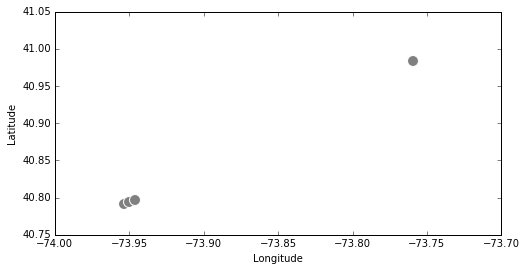

In [31]:
fig, ax = plt.subplots(figsize= (8,4))

ax.scatter(gmm.means_[:,1], gmm.means_[:,0],s=120, facecolor='0.5', lw = 1, edgecolor='w')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

### Who is commuter?
#### Commuters have typical travel pattern on weekdays. For example, commuters usually work from 8 to 5. It is usually home-based work trip therefore they tend to be at home before 8. They might go for other activities after work but will return home for the night. We can safely assume that most of data points are generated from home or work locations.

#### The way I approached this question:
* Find hidden locations with weights larger than 0.3 generated in the previous step of GMM application. If there is only one larger than 0.3, not a commuter. Jump to next otherwise.
* Group locations if they are extremely close to each other (considering measurement error). The threshold can be 500 meters.
* If locations can be grouped into 2 distinct location, one is assumed to be home and the other is work
    * If three locations are distinctly far from each other, no grouping.
* Look up time responding to 2 remaining locations. Work location time should be approximately between 8 and 5. Home otherwise. 
    * If there is no distinct time pattern, it is not a commuter.

#### Build a function to detemine whether it is a commuter or not; if so, home and work location; and corresponding time

In [32]:
home_time = [0,1,2,3,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24]
work_time = [7,8,9,10,11,12,13,14,15,16,17]

def Commuter(weights , means, weight_threshold, dist_threshold):
    
    if [x>weight_threshold for x in list(weights)].count(True) <= 1:
        
        # home, work, home_time, work_time
        home = list(compress(means, [x>weight_threshold for x in list(weights)]))[0]
        return (home[:2], np.nan, home[2], np.nan)

    elif [x>weight_threshold for x in list(weights)].count(True) == 2:

        hiddenlocs = list(compress(means, [x>weight_threshold for x in list(weights)]))

        locationa = hiddenlocs[0][:2][0], hiddenlocs[0][:2][1]
        locationb = hiddenlocs[1][:2][0], hiddenlocs[1][:2][1]
        dist = great_circle(locationa, locationb).meters
        
        if dist < dist_threshold:
            # just pick one
            home = list(compress(means, [x>weight_threshold for x in list(weights)]))[0]
            return (home[:2], np.nan, home[2], np.nan)
        
        else:
            hiddenloc1 = hiddenlocs[0]
            hiddenloc2 = hiddenlocs[1]
            if int(hiddenloc1[2]) in home_time and int(hiddenloc2[2]) in work_time:
                return (hiddenloc1[:2], hiddenloc2[:2], hiddenloc1[2], hiddenloc2[2])

            elif int(hiddenloc2[2]) in home_time and int(hiddenloc1[2]) in work_time:
                return (hiddenloc2[:2], hiddenloc1[:2], hiddenloc2[2], hiddenloc1[2])

            else:
                #pick one
                home = hiddenloc1
                return (home[:2], np.nan, home[2], np.nan)

    else:
        A=(list(weights))
        B=sorted(range(len(A)),key=lambda x:A[x],reverse=True)
        hiddenlocs = np.array([means[ind] for ind in B[:3]])

        close = []
        for pair in list(itertools.combinations(range(3), 2)):
            locationa = hiddenlocs[pair[0]][:2][0], hiddenlocs[pair[0]][:2][1]
            locationb = hiddenlocs[pair[1]][:2][0], hiddenlocs[pair[1]][:2][1]
            dist = great_circle(locationa, locationb).meters
            if dist < dist_threshold:
                close.append(pair)
        
        if len(close) == 1:
            # pick one location:
            hiddenloc1 = hiddenlocs[close[0][0]]
            hiddenloc2 = hiddenlocs[list(set([0,1,2])-set([x for x in close]))[0]]

            # continue look at time
            if int(hiddenloc1[2]) in home_time and int(hiddenloc2[2])in work_time:

                return (hiddenloc1[:2], hiddenloc2[:2], hiddenloc1[2], hiddenloc2[2])

            elif int(hiddenloc2[2]) in home_time and int(hiddenloc1[2]) in work_time:

                return (hiddenloc2[:2], hiddenloc1[:2], hiddenloc2[2], hiddenloc1[2])

            else:
                home = hiddenloc1
                return (home[:2], np.nan, home[2], np.nan)

        else:
            #pick one
            home = hiddenlocs[0]
            return (home[:2], np.nan, home[2], np.nan)

#### Get the list of names

In [33]:
names = [x[:-4] for x in os.listdir("new_york") if x[-4:] == '.csv' ]

#### Looping through individuals

In [34]:
allnames = []
home_loc = []
work_loc = []
home_t = []
work_t = []

for name in names:
    d = read_NY_NY(name)

    data = pd.DataFrame(data=d,index=range(0, len(d)),columns=['lat','lng','datetime'])

    # select weekday data
    data_weekday = data[data['datetime'].apply(lambda x: True if x.weekday() in range(0,5) else False)]

    data_weekday['hour'] = data_weekday['datetime'].apply(lambda x: x.hour)
    
    X = data_weekday[['lat','lng','hour']].as_matrix()
    
    gmm = mixture.GMM(n_components=4, covariance_type='full')
    gmm.fit(X)
    #Y_ = gmm.predict(X)
    
    allnames.append(name)
    
    a,b,c,d = Commuter(gmm.weights_, gmm.means_, 0.2, 500)
    home_loc.append(a)
    work_loc.append(b)
    home_t.append(c)
    work_t.append(d)

/Users/yiyange/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Format results

In [35]:
result = pd.DataFrame({'names': allnames,
             'home': home_loc,
             'work': work_loc,
            'home_time': home_t,
            'work_time': work_t})
result['Commuter'] = result['work'].apply(lambda x: x is np.nan)
result

,home,home_time,names,work,work_time,Commuter
0,"[40.7913732708, -73.9535683699]",16.471941,Ana,NaN,NaN,True
1,"[40.723459186, -74.0434513352]",20.686025,Billy,NaN,NaN,True
2,"[40.633873338, -74.0744926371]",20.110391,David,NaN,NaN,True
3,"[40.6695552185, -74.2731368179]",17.499309,Dianne,"[40.6706017347, -74.2506374916]",9.588511,False
4,"[40.6088580698, -74.3732562019]",13.001295,Donald,NaN,NaN,True
5,"[40.7271555667, -73.9852619104]",18.935693,Elisabeth,NaN,NaN,True
6,"[40.7432886812, -74.0088088816]",20.043107,Garland,"[40.7614158798, -73.6945165151]",11.938013,False
7,"[40.716341347, -73.982317709]",19.521964,George,"[40.7209983405, -73.9854003415]",11.868208,False
8,"[40.8222090048, -73.9726948148]",20.174708,Heather,"[40.8242660688, -73.9628299991]",10.727971,False
9,"[40.7053462602, -73.982270673]",17.606085,Hilda,"[40.7101866208, -73.9753569944]",12.297168,False
